In [37]:
import numpy as np
import os
import glob
import logging
import json
import sys
sys.path.append("/workspace/zecheng/modelzipper/projects")
from tqdm import tqdm
from concurrent import futures
from argparse import ArgumentParser
from change_deepsvg.svglib.svg import SVG
from change_deepsvg.svglib.geom import Bbox, Angle, Point
from change_deepsvg.difflib.tensor import SVGTensor
from modelzipper.tutils import *
import torch
from tqdm import trange
from PIL import Image

# content = auto_read_data("/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/compress_level_1_predictions.pkl")

def sanint_check_svg_tensor(x):
    """
    x: batch_size x seq_len x (7, 9)
    """
    if x.ndim == 2:
        x = x.unsqueeze(0)
    if x.size(-1) == 9:
        x[:, :, 0][x[:, :, 0] == 100] = 1
        x[:, :, 0][x[:, :, 0] == 200] = 2
    elif x.size(-1) == 7:
        # add two columns
        x_0_y_0 = torch.zeros((x.size(0), x.size(1), 2), dtype=x.dtype, device=x.device)
        x_0_y_0[:, 1:, 0] = x[:, :-1, -2]  # x_3 of the previous row
        x_0_y_0[:, 1:, 1] = x[:, :-1, -1]  # y_3 of the previous row
        x = torch.cat((x[:, :, :1], x_0_y_0, x[:, :, 1:]), dim=2)
    return x

def convert_svg(t, colored=False):
    svg = SVGTensor.from_data(t)
    svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    svg.numericalize(n=200)
    if colored:
        svg = svg.normalize().split_paths().set_color("random")
    str_svg = svg.to_str()
    return svg, str_svg


def merge_images(
        image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10,
    ):
    image_list = []
    for image_path in image_path_lst:
        image = Image.open(image_path)
        image_list.append(image)

    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    big_image_size = (sub_image_w * image_row, sub_image_h * image_col)
    big_image = Image.new('RGB', big_image_size)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_row
        col = i % image_col
        big_image.paste(image, (col * image.size[0], row * image.size[1]))
        
        if (i + 1) % (image_row * image_col) == 0:
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size)

    return big_images


def open_image_with_gray_background(image_path, background_color=(255, 255, 255)):  
    # 打开图片并转换为RGBA模式以处理透明度  
    image = Image.open(image_path).convert('RGBA')  
      
    # 创建一个与原图大小相同的灰色背景图像  
    gray_background = Image.new('RGBA', image.size, background_color + (255,))  
      
    # 将原始图像粘贴到灰色背景图像上，透明部分将显示为灰色  
    combined_image = Image.alpha_composite(gray_background, image)  
      
    # 将合成图像转换回RGB模式，以便用于其他不支持透明度的操作  
    combined_image = combined_image.convert('RGB')  
      
    return combined_image 


def merge_images2(
    image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10, gap_size=10, grid_color=(255, 255, 255), scale_factor=2.0, 
):
    image_list = []
    for image_path in image_path_lst:
        image = open_image_with_gray_background(image_path)
        # image = Image.open(image_path).convert('RGB')
        image = image.resize((int(image.size[0] * scale_factor), int(image.size[1] * scale_factor)))  
        image_list.append(image) 

    
    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    # 计算包括网格线和空隙在内的大图尺寸
    total_gap_w = (image_col - 1) * gap_size + gap_size * 2
    total_gap_h = (image_row - 1) * gap_size + gap_size * 2
    # print(sub_image_w, image_col, total_gap_w)
    big_image_size = (sub_image_w * image_col + total_gap_w, sub_image_h * image_row + total_gap_h)

    # 创建带有网格线和空隙的大图背景
    big_image = Image.new('RGB', big_image_size, color=grid_color)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_col
        col = i % image_col

        x_pos = col * (sub_image_w + gap_size) + gap_size
        y_pos = row * (sub_image_h + gap_size) + gap_size

        big_image.paste(image, (x_pos, y_pos))
        
        # 每满一张大图，就将其添加到big_images列表中，并创建新的大图
        if (i + 1) % (image_row * image_col) == 0 or (i + 1) == len(image_list):
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size, color=grid_color)

    # # 如果提供了保存目录，则将大图保存为PDF
    # if save_dir:
    #     for index, big_image in enumerate(big_images):
    #         save_path = f"{save_dir}/big_image_{index}.{image_suffix}"
    #         big_image.save(save_path)

    #     # 将所有大图合并为单个PDF文件
    #     big_images[0].save(f"{save_dir}/merged_images.pdf", save_all=True, append_images=big_images[1:])

    return big_images




In [2]:
content_1 = auto_read_data("/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/compress_level_1_predictions.pkl")

begin to read data from /zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/compress_level_1_predictions.pkl ...


In [6]:
content_1.keys()

dict_keys(['raw_predict', 'p_predict1', 'p_predict2', 'golden'])

## Analysis

In [ ]:

anaylsis_id = [250, 271, 329, 295]

COMPRESS_1 = "/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/visualized_compress_level_1/single_image"
COMPRESS_2 = "/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/visualized_compress_level_2/single_image"


SUFFIX_P1, SUFFIX_P2, GOLDEN = "{id}_p_svg1.png", "{id}_p_svg2.png", "{id}_g_svg.png"

compress1_p1 = [os.path.join(COMPRESS_1, SUFFIX_P1.format(id=i)) for i in anaylsis_id]
compress1_p2 = [os.path.join(COMPRESS_1, SUFFIX_P2.format(id=i)) for i in anaylsis_id]
compress2_p1 = [os.path.join(COMPRESS_2, SUFFIX_P1.format(id=i)) for i in anaylsis_id]
compress1_g = [os.path.join(COMPRESS_1, GOLDEN.format(id=i)) for i in anaylsis_id]

all_images_0 = [compress1_p2[0]] + [compress1_p1[0]] + [compress2_p1[0]] + [compress1_g[0]]
all_images_1 = [compress1_p2[1]] + [compress1_p1[1]] + [compress2_p1[1]] + [compress1_g[1]]
all_images_2 = [compress1_p2[2]] + [compress1_p1[2]] + [compress2_p1[2]] + [compress1_g[2]]
all_images_3 = [compress1_p2[3]] + [compress1_p1[3]] + [compress2_p1[3]] + [compress1_g[3]]

all_images = all_images_0 + all_images_1 + all_images_2 + all_images_3


big_map1 = merge_images2(image_path_lst=all_images, image_row=4, image_col=4, gap_size=5, grid_color = (0, 0, 0))[0]
big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/analysis_white.pdf")


## Merge Big Figures 

In [3]:
ID = [0, 5, 52, 117, 147, 246, 378, 490, 447, 486, 590, 526, 661, 610, 631, 736, 879, 856, 836, 972, 960, 979, 1038, 1081, 1250, 1284, 1293, 1326, 1407, 1534, 1594, 1740, 1780]  #35

In [39]:
# ID = [972, 147, 486, 526, 979]  #35
ID = [36, 196, 200, 463, 494, 1202, 977, 815]
sampled_ID = [36, 196, 200, 1202,815]
num_rows = 5

# sampled_ID = ID
# sampled_ID = random.sample(ID, num_rows)

print(sampled_ID)

# COMPRESS_1 = "/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/visualized_compress_level_1/single_image"

# COMPRESS_2 = "/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/normal/visualized_compress_level_2/single_image"

# COMPRESS_1 = "/zecheng2/vqllama/test_vqllama_quantizer/test_14/epoch_75/all/visualized_compress_level_1/single_image"
# COMPRESS_2 = "/zecheng2/vqllama/test_vqllama_quantizer/test_14/epoch_75/all/visualized_compress_level_2/single_image"

COMPRESS_1 = "/workspace/zecheng/modelzipper/projects/custom_llama/tmp_save_png/reconstruction/CL1"
COMPRESS_2 = "/workspace/zecheng/modelzipper/projects/custom_llama/tmp_save_png/reconstruction/CL2"

SUFFIX_P1, SUFFIX_P2, GOLDEN = "{id}_p_svg1.png", "{id}_p_svg2.png", "{id}_g_svg.png"


compress1_p1 = [os.path.join(COMPRESS_1, SUFFIX_P1.format(id=i)) for i in sampled_ID]
compress1_p2 = [os.path.join(COMPRESS_1, SUFFIX_P2.format(id=i)) for i in sampled_ID]
compress1_g = [os.path.join(COMPRESS_1, GOLDEN.format(id=i)) for i in sampled_ID]
compress2_p1 = [os.path.join(COMPRESS_2, SUFFIX_P1.format(id=i)) for i in sampled_ID]
compress2_p2 = [os.path.join(COMPRESS_2, SUFFIX_P2.format(id=i)) for i in sampled_ID]
compress2_g = [os.path.join(COMPRESS_2, GOLDEN.format(id=i)) for i in sampled_ID]



merge_sample_lst1 = compress1_p1[:num_rows] + compress1_p2[:num_rows] + compress2_p1 + compress1_g[:num_rows]

# merge_sample_lst2 = compress1_p1[num_rows:num_rows*2] + compress1_p2[num_rows:num_rows*2] + compress1_g[num_rows:num_rows*2]

big_map1 = merge_images2(image_path_lst=merge_sample_lst1, image_row=4, image_col=num_rows, gap_size=5, grid_color = (0, 0, 0))[0]
# big_map2 = merge_images2(image_path_lst=merge_sample_lst2, image_row=3, image_col=num_rows, gap_size=5, grid_color = (0, 0, 0))[0]

big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_1_white.png")
# big_map2.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_2_white.pdf")

[36, 196, 200, 1202, 815]


In [27]:
merge_sample_lst3 = merge_sample_lst1 + merge_sample_lst2

big_map1 = merge_images2(image_path_lst=merge_sample_lst3, image_row=6, image_col=12, gap_size=5)[0]
# big_map2 = merge_images2(image_path_lst=merge_sample_lst2, image_row=3, image_col=12, gap_size=5)[0]

big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_3.pdf")
# big_map2.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_2.pdf")

## Analysis single image

In [9]:
p_predict = content['p_predict']
raw_predict = content['raw_predict']
golden = content['golden']

sample_p_0 = p_predict[0]
sample_r_0 = raw_predict[0]
sample_g_0 = golden[0] 

sample_p_0 = sanint_check_svg_tensor(sample_p_0).squeeze(0)
sample_r_0 = sanint_check_svg_tensor(sample_r_0).squeeze(0)
sample_g_0 = sanint_check_svg_tensor(sample_g_0).squeeze(0)

print(sample_p_0.shape)
print(sample_r_0.shape)
print(sample_g_0.shape)

torch.Size([278, 9])
torch.Size([200, 9])
torch.Size([200, 9])


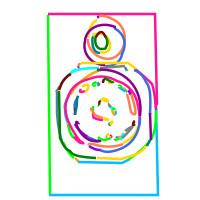

In [10]:

svg = SVGTensor.from_data(sample_p_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
# svg.animate(frame_duration=0.1)

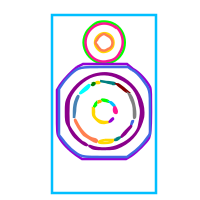

In [13]:

svg = SVGTensor.from_data(sample_g_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
# svg.animate(frame_duration=0.1)

In [19]:
tmp = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/snap_0_results.pkl")

begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/snap_0_results.pkl ...


In [18]:
len(tmp)

{'keywords': ['speaker'],
 'mesh_data': tensor([[  0.,   0.,   0.,  ...,   0.,   4., 104.],
         [  1.,   4., 104.,  ...,   0.,   4., 199.],
         [  1.,   4., 199.,  ...,   0., 199., 199.],
         ...,
         [  2., 113., 140.,  ..., 140., 113., 140.],
         [  2., 113., 140.,  ..., 140., 105., 140.],
         [  1., 105., 140.,  ...,   0., 105., 140.]])}

In [16]:
def remove_padding(x, padding_mask):
    """
    x: (batch_size x) seq_len num_bins
    padding: seq_len x num_bins

    if batch, return List[Tensor]
    if tensor, return Tensor
    """
    if x.ndim == 2:  # seq_len x num_bins
        return x[:padding_mask.sum(), :]
    elif x.ndim == 3:  # batch_size x seq_len x num_bins
        res = []
        for i in range(x.size(0)):
            res.append(x[i, :padding_mask[i].sum(), :])
        return res

def postprocess(x, padding_mask=None, path_interpolation=True):
    """
    postprocess the generated results

    x: batch_size x seq_len x 9
    padding_mask: batch_size x seq_len
    path_interpolation: whether to interpolate the path
    """
    dtype = x.dtype
    if x.ndim == 2:
        x = x.unsqueeze(0)
    if padding_mask.ndim == 1:
        padding_mask = padding_mask.unsqueeze(0)

    if path_interpolation:  
        # conduct path interpolation
        # return List[Tensor]
        batch_size = x.size(0)
        x = remove_padding(x, padding_mask)  # remove the padding
        full_x = []
        for i in range(batch_size):
            current_path = []
            last_x3, last_y3 = None, None
            seq_len = x[i].size(0)
            for j in range(seq_len):
                row = x[i][j]
                cmd = 100 * torch.round(row[0] / 100).item()
                cmd = 1 if cmd == 100 else 2 if cmd == 200 else 0
                x0, y0, x1, y1, x2, y2, x3, y3 = map(lambda coord: min(max(coord, 0), 200), row[1:].tolist())
                if last_x3 is not None and (last_x3 != x0 or last_y3 != y0):
                    # if the current row's start point is not the same as the previous row's end point
                    current_path.append([0, last_x3, last_y3, 0, 0, 0, 0, x0, y0])
                if cmd in [0, 100]:
                    # if the current row is M or L, set control point to 0
                    x1, y1, x2, y2 = 0, 0, 0, 0
                current_path.append([cmd, x0, y0, x1, y1, x2, y2, x3, y3])
                last_x3, last_y3 = x3, y3  # update the last end point
            full_x.append(torch.tensor(current_path, dtype=dtype))
    
    else:  # no path interpolation
        if x.size(-1) == 9:
            # first remove the 1, 2 columns
            m_x = torch.cat((x[:, :, :1], x[:, :, 3:]), dim=2)
        else:
            m_x = x
        # find the right command value
        m_x[:, :, 0] = torch.round(m_x[:, :, 0] / 100) * 100
        # clip all the value to max bins 
        m_x = torch.clamp(m_x, 0, 200)
        # process the M and L path                                                              
        m_x[:, :, 1:5][m_x[:, :, 0] != 200] = 0
        # add to extra column to satisfy the 9 columns
        x_0_y_0 = torch.zeros((m_x.size(0), m_x.size(1), 2), dtype=m_x.dtype, device=m_x.device)
        x_0_y_0[:, 1:, 0] = m_x[:, :-1, -2]  # x_3 of the previous row
        x_0_y_0[:, 1:, 1] = m_x[:, :-1, -1]  # y_3 of the previous row
        full_x = torch.cat((m_x[:, :, :1], x_0_y_0, m_x[:, :, 1:]), dim=2)
        # replace the command value to 0, 1, 2
        full_x[:, :, 0][full_x[:, :, 0] == 100] = 1
        full_x[:, :, 0][full_x[:, :, 0] == 200] = 2
        # remove the padding
        full_x = remove_padding(full_x, padding_mask)

    return full_x

In [15]:

svg = SVGTensor.from_data(sample_r_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
svg.animate(frame_duration=0.1)

ValueError: 'SOS' is not a valid SVGCmdEnum